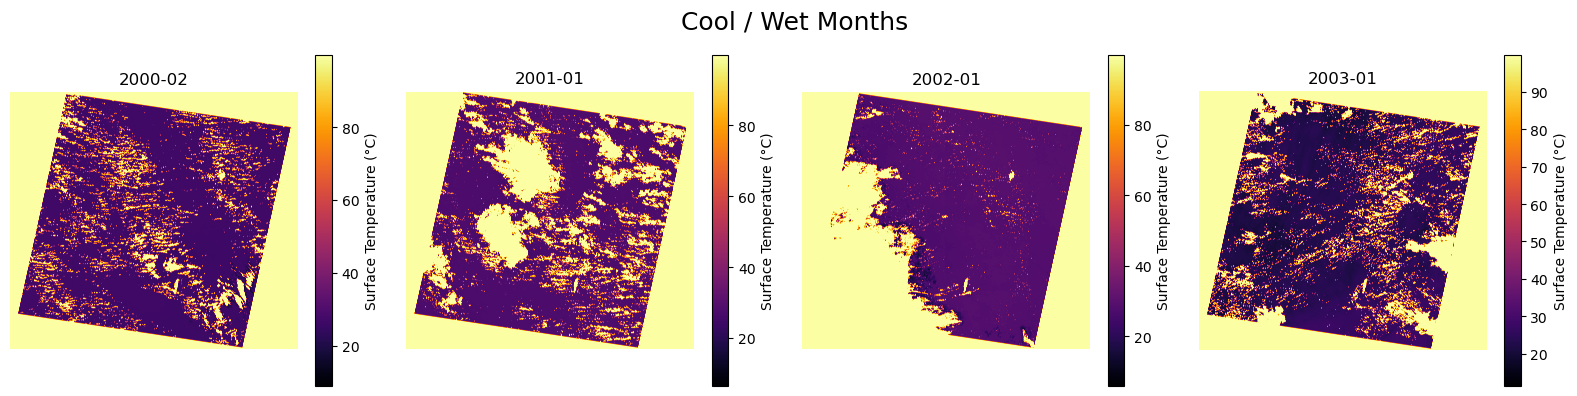

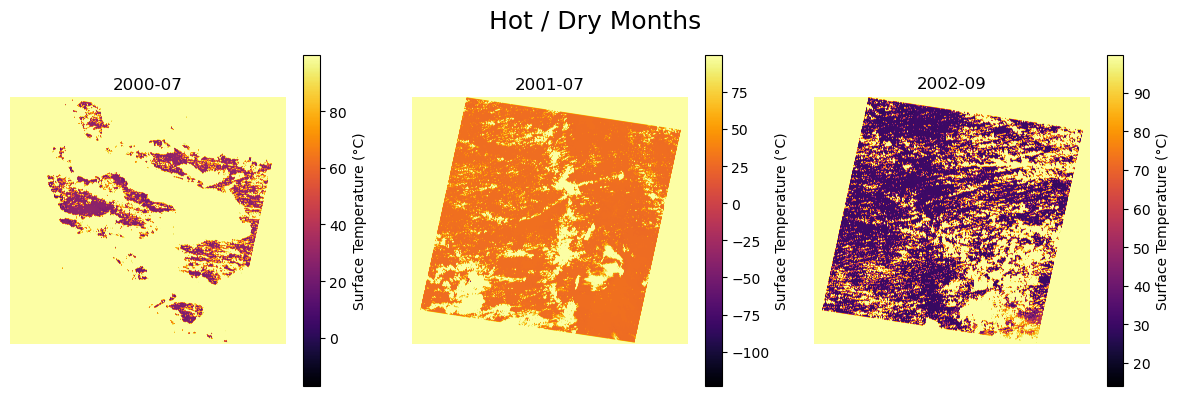

In [28]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


# File list and matching date labels for each scene

tif_files = ["L7Mask_2000_02.TIFF",
             "L7Mask_2000_07.TIFF",
             "L7Mask_2001_01.TIFF",
             "L7Mask_2001_07.TIFF",
             "L7Mask_2002_01.TIFF",
             "L7Mask_2002_09.TIFF",
             "L7Mask_2003_01.TIFF"
            ]
dates = ["2000-02","2000-07","2001-01","2001-07","2002-01","2002-09","2003-01"]


#Landsat Level-2 Surface Temperature scale factors

MULT = 0.00341802     # scale factor
ADD  = 149.0          # additive offset before °C conversion

scenes = []


# Convert each scene and visualize

for tif, date in zip(tif_files, dates):
    with rasterio.open(tif) as src:
        DN = src.read(1).astype("float32")

    # Remove fill values
    DN[DN == 0] = np.nan

    # Convert DN → Kelvin → Celsius
    tempC = (DN * MULT + ADD) - 273.15

    scenes.append(tempC)

# New code seperating cool and dry month
cool_indices = [0, 2, 4, 6]   # Feb & Jan scenes
dry_indices  = [1, 3, 5]      # July & Sept scenes

# ------- COOL MONTHS -------
plt.figure(figsize=(16,4))
for i, idx in enumerate(cool_indices):
    plt.subplot(1, len(cool_indices), i+1)
    plt.imshow(scenes[idx], cmap="inferno")
    plt.title(dates[idx])
    plt.colorbar(label="Surface Temperature (°C)")
    plt.axis("off")
plt.suptitle("Cool / Wet Months", fontsize=18)
plt.tight_layout()
plt.show()

# ------- DRY MONTHS -------
plt.figure(figsize=(12,4))
for i, idx in enumerate(dry_indices):
    plt.subplot(1, len(dry_indices), i+1)
    plt.imshow(scenes[idx], cmap="inferno")
    plt.title(dates[idx])
    plt.colorbar(label="Surface Temperature (°C)")
    plt.axis("off")
plt.suptitle("Hot / Dry Months", fontsize=18)
plt.tight_layout()
plt.show()

In [29]:
import pandas as pd

stats = []

#store all data into 'img' and then zip them together using dates, scenes
for date, img in zip(dates, scenes):
    stats.append({
        "date": date,
        #all the nan... ignores invalid pixels
        "mean": np.nanmean(img),
        "min": np.nanmin(img),
        "max": np.nanmax(img),
        "std": np.nanstd(img)
    })


#stores all the statistics into a pandas dataframe
df_stats = pd.DataFrame(stats)
print(df_stats)
df_stats.to_csv("sst_stats.csv", index=False)

      date       mean         min        max        std
0  2000-02  56.838707    8.875946  99.849945  36.172714
1  2000-07  92.794746  -17.060028  99.849945  21.902500
2  2001-01  64.937134    6.455963  99.849945  36.232616
3  2001-07  60.092628 -123.148514  99.849945  35.961121
4  2002-01  63.504208    5.878326  99.849945  36.034264
5  2002-09  70.647072   13.924347  99.849945  34.660645
6  2003-01  58.110104   11.357391  99.849945  38.025734


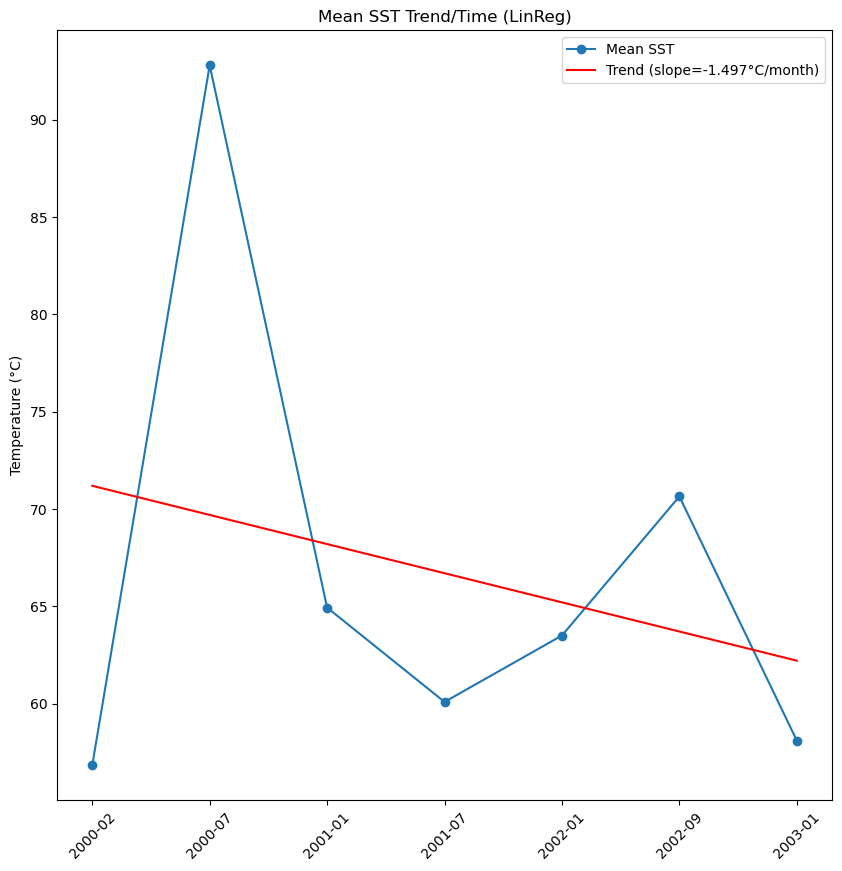

p-value: 0.5725998419199811


In [30]:
import matplotlib.pyplot as plt
#imported SciPys linregress function to do linear regression using Ordinary least squares to find the best fitted line.
from scipy.stats import linregress


#assign an index to each date i.e., x = 0 corresponds to 2000-02
x = np.arange(len(df_stats))  # index 0→6
#storing the average temperature of the scenes into y
y = df_stats["mean"].values


#this performs the OLS linear regression the ordinary least squares, which finds the best fitted line
#slope - change in temp/time
#intercept - predicted temp at time step 0
#r - correlation between time and temp
#p statistical significance between trend
#uncertainty in the slope estimate
#Essentially, the regression model calculates the straight line best 
#matching the pattern of the mean temps over time and minimizing the error between the line and data points
slope, intercept, r, p, stderr = linregress(x, y)

plt.figure(figsize=(10,10))

#blue line depicts the actual mean temps
#red line depicts the fitted regression trend
plt.plot(df_stats["date"], y, marker="o", label="Mean SST")
plt.plot(df_stats["date"], intercept + slope*x, 'r', label=f"Trend (slope={slope:.3f}°C/month)")

plt.xticks(rotation=45)
plt.ylabel("Temperature (°C)")
plt.title("Mean SST Trend/Time (LinReg)")
plt.legend()
plt.show()
print("p-value:", p)

Trend: no trend
H (True if trend is present): False
P-value: 1.0
Z-statistic: 0.0
Mann-Kendall S: -1.0
Variance of S: 44.333333333333336
Sen's slope: -0.6608416239420573
Intercept: 65.48673248291016


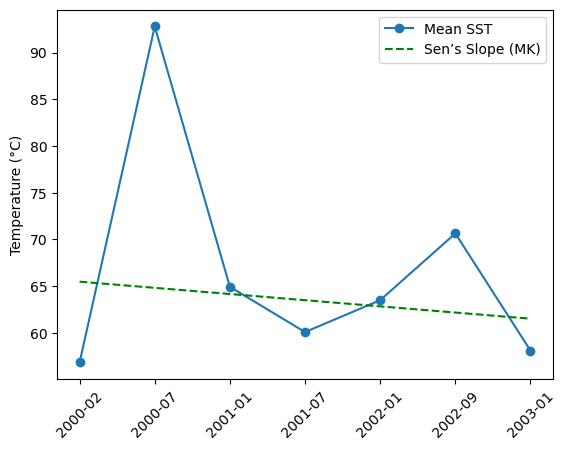

In [31]:
#Mann-Kendall Test
!pip install pymannkendall
import numpy as np
import pymannkendall as mk

data = df_stats["mean"].values
y = df_stats["mean"].values
years = df_stats["date"]


# Correct function name:
result = mk.original_test(data)

print(f"Trend: {result.trend}")
print(f"H (True if trend is present): {result.h}")
print(f"P-value: {result.p}")
print(f"Z-statistic: {result.z}")
print(f"Mann-Kendall S: {result.s}")
print(f"Variance of S: {result.var_s}")
print(f"Sen's slope: {result.slope}")
print(f"Intercept: {result.intercept}")

x_numeric = np.arange(len(y))

mk_result = mk.original_test(y)

sen_line = mk_result.intercept + mk_result.slope * x_numeric

plt.plot(years, y, 'o-', label="Mean SST")
plt.plot(years, sen_line, 'g--', label="Sen’s Slope (MK)")
plt.xticks(rotation=45)
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()